In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley.kriging import KrigingIndices
from shapley.tests.test_functions import ishigami, ot_ishigami, ishigami_true_indices
from shapley.plots import set_style_paper

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
dim = 3
model = ot.PythonFunction(dim, 1, ot_ishigami)
margins = [ot.Uniform(-np.pi, np.pi)]*dim
copula = ot.IndependentCopula(dim)
input_distribution = ot.ComposedDistribution(margins, copula)

## Sobol indices

In [3]:
columns_first = ['n_sample']
for i in range(dim):
    columns_first.append('S_%d' % (i+1))
    columns_first.append('S_%d_down' % (i+1))
    columns_first.append('S_%d_up' % (i+1))
    
columns_total = ['n_sample']
for i in range(dim):
    columns_total.append('St_%d' % (i+1))
    columns_total.append('St_%d_down' % (i+1))
    columns_total.append('St_%d_up' % (i+1))

In [4]:
n_exp = 10
alpha = 0.95
n_samples = np.linspace(100, 1000, n_exp)
results_first = pd.DataFrame(np.zeros((n_exp, len(columns_first))), columns=columns_first)
results_total = pd.DataFrame(np.zeros((n_exp, len(columns_total))), columns=columns_total)
for k, n_sample in enumerate(n_samples):
    results_first.loc[k, 'n_sample'] = int(n_sample)
    results_total.loc[k, 'n_sample'] = int(n_sample)
    input_design = ot.SobolIndicesAlgorithmImplementation.Generate(input_distribution, int(n_sample), True)
    output_design = model(input_design)
    sensitivity = ot.SaltelliSensitivityAlgorithm(input_design, output_design, int(n_sample))
    sensitivity.setBootstrapConfidenceLevel(alpha)
    indices = np.asarray(sensitivity.getFirstOrderIndices())
    indices_intervals = sensitivity.getFirstOrderIndicesInterval()
    indices_interval_down = np.asarray(indices_intervals.getLowerBound())
    indices_interval_up = np.asarray(indices_intervals.getUpperBound())
    total_indices = np.asarray(sensitivity.getTotalOrderIndices())
    total_indices_intervals = sensitivity.getTotalOrderIndicesInterval()
    total_indices_intervals_down = np.asarray(total_indices_intervals.getLowerBound())
    total_indices_intervals_up = np.asarray(total_indices_intervals.getUpperBound())
    for i in range(dim):
        results_first.loc[k, 'S_%d' % (i+1)] = indices[i]
        results_first.loc[k, 'S_%d_down' % (i+1)] = indices_interval_down[i]
        results_first.loc[k, 'S_%d_up' % (i+1)] = indices_interval_up[i]
        results_total.loc[k, 'St_%d' % (i+1)] = total_indices[i]
        results_total.loc[k, 'St_%d_down' % (i+1)] = total_indices_intervals_down[i]
        results_total.loc[k, 'St_%d_up' % (i+1)] = total_indices_intervals_up[i]

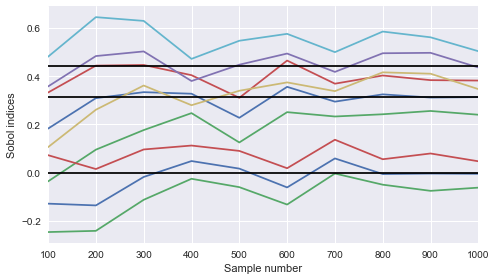

In [5]:
fig, ax = plt.subplots(figsize=(7, 4))
results_first.plot(x='n_sample', legend=False, ax=ax)
x = [n_samples[0], n_samples[-1]]
for i in range(dim):
    true_indice = ishigami_true_indices[i]
    ax.plot(x, [true_indice]*2, 'k')
ax.set_ylabel('Sobol indices')
ax.set_xlabel('Sample number')
fig.tight_layout()

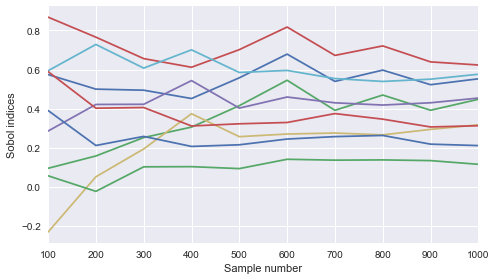

In [6]:
fig, ax = plt.subplots(figsize=(7, 4))
results_total.plot(x='n_sample', legend=False, ax=ax)
ax.set_ylabel('Sobol indices')
ax.set_xlabel('Sample number')
fig.tight_layout()

## Sobol with kriging

In [124]:
kriging = KrigingIndices(model, input_distribution)
kriging.build_model(n_sample_kriging=1000)

In [133]:
n_realization = 30
n_bootstrap = 100
first_indices = kriging.compute_indices(n_sample=3000, n_realization=n_realization, n_bootstrap=n_bootstrap)

In [137]:
first_indices_estimates = [first_indices[i, :, 0].mean() for i in range(dim)]
first_indices_estimates

[0.29300416067711477, 0.41827371706856753, -0.016745570681940332]

In [138]:
first_indices_estimates = [first_indices[i].mean() for i in range(dim)]
first_indices_estimates

[0.2933412483254465, 0.41814806122578951, -0.016558679076072367]

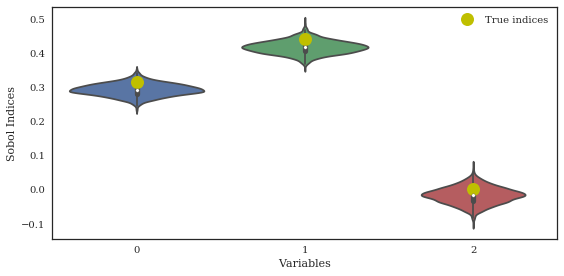

In [141]:
set_style_paper()
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(data=first_indices[:, :].reshape(dim, -1).T, ax=ax, label='First order indices');
ax.plot(range(3), ishigami_true_indices, 'yo', markersize=13, label='True indices')

ax.set_xlabel('Variables')
ax.set_ylabel('Sobol Indices')
ax.legend(loc=0)
fig.tight_layout()

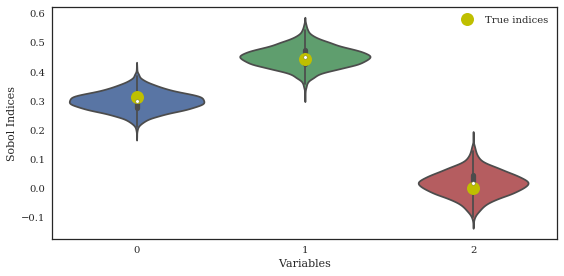

In [131]:
set_style_paper()
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(data=first_indices[:, :].reshape(dim, -1).T, ax=ax, label='First order indices');
ax.plot(range(3), ishigami_true_indices, 'yo', markersize=13, label='True indices')

ax.set_xlabel('Variables')
ax.set_ylabel('Sobol Indices')
ax.legend(loc=0)
fig.tight_layout()

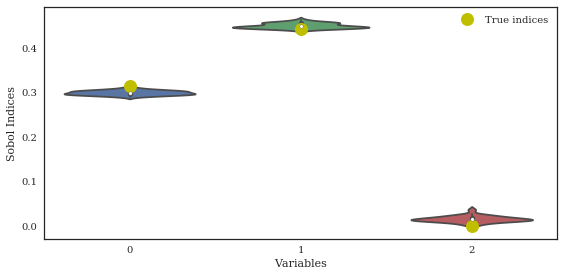

In [132]:
set_style_paper()
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(data=first_indices[:, :, 0].T, ax=ax, label='First order indices');
ax.plot(range(3), ishigami_true_indices, 'yo', markersize=13, label='True indices')

ax.set_xlabel('Variables')
ax.set_ylabel('Sobol Indices')
ax.legend(loc=0)
fig.tight_layout()

In [65]:
realization = rvector.getRealization()

In [99]:
input_sample_1 = np.asarray(kriging.input_distribution.getSample(10))
seed = ot.RandomGenerator.GetState()
rvector = ot.KrigingRandomVector(kriging.kriging_result, input_sample_1)
rvector.getRealization()

class=Point name=Unnamed dimension=10 values=[-0.906722,7.44605,1.85578,6.7188,6.70799,4.81236,4.75573,1.91592,6.02836,6.74858]

In [100]:
rvector.getRealization()

class=Point name=Unnamed dimension=10 values=[-0.280744,9.00618,1.00262,6.12045,6.20306,5.16359,4.8315,1.86712,5.52787,7.18458]

In [103]:
ot.RandomGenerator.SetState(seed)
rvector.getRealization()

class=Point name=Unnamed dimension=10 values=[-0.906722,7.44605,1.85578,6.7188,6.70799,4.81236,4.75573,1.91592,6.02836,6.74858]

In [18]:
i = 0
for i_nz in range(n_realization):
    for i_b in range(n_bootstrap):
        pass

In [135]:
def sobol_estimator(func, X, Xt):
    """
    """
    Y = func(X)
    Yt = func(Xt)
    partial = (Y * Yt).mean() - Y.mean()*Yt.mean()
    total = (Y**2).mean() - Y.mean()**2
    return partial / total

def janon_estimator(func, X, Xt):
    """
    """
    n_sample = X.shape[0]
    Xall = np.r_[X, Xt]
    Yall = func(Xall)
    Y = Yall[:n_sample]
    Yt = Yall[n_sample:]
    partial = (Y * Yt).mean() - ((Y + Yt).mean()*0.5)**2
    total = (Y**2).mean() - ((Y + Yt).mean()*0.5)**2
    return partial / total

def janon_estimator(output_design):
    """
    """
    n_sample = output_design.shape[0]
    Y = output_design[:n_sample]
    Yt = output_design[n_sample:]
    partial = (Y * Yt).mean() - ((Y + Yt).mean()*0.5)**2
    total = (Y**2).mean() - ((Y + Yt).mean()*0.5)**2
    return partial / total

n_sample = 20000
func = ishigami

input_sample_1 = np.asarray(input_distribution.getSample(n_sample))
input_sample_2 = np.asarray(input_distribution.getSample(n_sample))

def compute_indices(func, input_sample_1, input_sample_2):
    """
    """
    dim = input_sample_1.shape[1]
    indices = np.zeros((dim,))
    for i in range(dim):
        X = input_sample_1
        Xt = input_sample_2.copy()
        Xt[:, i] = input_sample_1[:, i]
        indices[i] = janon_estimator(func, X, Xt)
    return indices

In [136]:
indices

array([ 0.31169485,  0.43883455,  0.00990758])

In [137]:
first_indices = kriging.compute_indices(n_sample=100, n_realization=n_realization, n_bootstrap=n_bootstrap)

AttributeError: 'KrigingIndices' object has no attribute 'kriging_function'